In [31]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import savgol_filter

In [32]:
from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter
from summer2.functions import get_piecewise_scalar_function

**Model 2: SEIQR (Stratified Infectious Compartment)**

In [33]:
def build_model():
    m = CompartmentalModel([0,500], ["S","E","I","Q","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 1153.0, "Q": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", get_piecewise_scalar_function([Parameter("breakpt1"),Parameter("breakpt2")], [Parameter("rate1"),Parameter("multiplier1")*Parameter("rate1"),Parameter("multiplier2")*Parameter("rate1")]),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("notification", Parameter("detection_rate"),"I","Q")
    m.add_transition_flow("recovery_from_Q", 0.0714,"Q","R") 
    m.add_transition_flow("recovery__from_I", 0.0714,"I","R") 
    #m.add_death_flow("infection_death", Parameter("death_rate"), "I")
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("notification", "notification")
    #m.request_output_for_flow("infection_death", "infection_death")
    #m.request_cumulative_output(name="deaths_cumulative", source="infection_death")
    m.request_output_for_compartments(name="active", compartments=["Q"])

    strata = ["asymptomatic", "symptomatic"]
    strat = Stratification(name="severity", strata=strata, compartments=['I'])

    strat.set_population_split({"asymptomatic": 0.18, "symptomatic": 0.82})

    strat.set_flow_adjustments("progression", {
    "asymptomatic": None,
    "symptomatic": Multiply(Parameter("symp_prop")),
    })

    strat.set_flow_adjustments("notification", {
    "asymptomatic": Multiply(Parameter("asymp_det")),
    "symptomatic": None,
    })

    #strat.set_flow_adjustments("infection_death", {
    #"asymptomatic": Multiply(Parameter("asymp_death")),
    #"symptomatic": None,
    #})

    return m, strat

In [34]:
m, strat = build_model()
m.stratify_with(strat)

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_60596/313886924.py:4: DeprecationWarning:

This method is deprecated and scheduled for removal, use get_piecewise_function instead



In [35]:
#parameters = {"breakpt1": 63, "breakpt2": 79, "rate1": 0.3, "multiplier1": 0.5, "multiplier2": 0.9, "detection_rate": 0.1, "symp_prop": 4.5, "asymp_det": 0.2, "death_rate": 0.01, "asymp_death": 0.3}
parameters = {"breakpt1": 63, "breakpt2": 79, "rate1": 0.3, "multiplier1": 0.5, "multiplier2": 0.9, "detection_rate": 0.1, "symp_prop": 4.5, "asymp_det": 0.2}

In [36]:
m.run(parameters)

In [37]:
fig = px.line(m.get_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [38]:
fig = px.line(m.get_derived_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [39]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["NOTIFICATIONS"]
death_data = df["CUMULATIVE DEATHS"]

In [40]:
notification_smoothed = savgol_filter(notification_data, window_length=12, polyorder=2)
notification_smoothed = pd.DataFrame(notification_smoothed, index=notification_data.keys())
notification_smoothed = notification_smoothed[0]

In [41]:
fig = px.line(notification_data)
fig = fig.add_trace(go.Scatter(x = notification_smoothed.keys(), y=notification_smoothed, name = "smoothed"))
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [42]:
notification_target = notification_smoothed[:90]
#death_data_cal = death_data[:90:2]

In [43]:
fig = px.scatter(notification_target)
fig.show()
#death_data_cal.plot(style='.')

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Optimization**

In [57]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [58]:
# Import nevergrad
import nevergrad as ng

# Import our convenience wrapper
from estival.wrappers.nevergrad import optimize_model

In [59]:
targets = [
    #est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1)
    est.TruncatedNormalTarget("notification", notification_target, (0.0,np.inf),
        esp.UniformPrior("notification_dispersion",(0.1, notification_target.max()*0.1))),
    #est.NormalTarget("deaths_cumulative", death_data_cal, np.std(death_data_cal) * 0.1)
]

In [60]:
priors = [
    esp.TruncNormalPrior("breakpt1",63.0,2.0,(59.0,67.0)),
    esp.TruncNormalPrior("breakpt2",79.0,2.0,(75.0,83.0)),
    esp.UniformPrior("rate1", (0,0.5)),
    esp.UniformPrior("multiplier1", (0,1)),
    esp.UniformPrior("multiplier2", (0.6,1)),
    esp.UniformPrior("detection_rate", (0,0.5)),
    esp.UniformPrior("symp_prop", (1,6)),
    esp.UniformPrior("asymp_det", (0,1)),
    #esp.UniformPrior("death_rate", (0,0.1)),
    #esp.UniformPrior("asymp_death", (0,0.7)),
]

In [61]:
defp = parameters

In [62]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)

In [63]:
# TwoPointsDE is a good suggested default for some of our typical use cases
opt_class = ng.optimizers.TwoPointsDE
orunner = optimize_model(bcm, opt_class=opt_class)

In [64]:
# You can also suggest starting points for the optimization (as well as specify an init method for unsuggested points)
# This is the "midpoint" method by default (ie the 0.5 ppf of the prior distribution)
orunner = optimize_model(bcm, opt_class=opt_class, suggested=defp, init_method="midpoint")

In [70]:
# Here we run the optimizer in a loop, inspecting the current best point at each iteration
# Using the loss information at each step can provide the basis for stopping conditions

for i in range(8):
    # Run the minimizer for a specified 'budget' (ie number of evaluations)
    rec = orunner.minimize(1000)
    # Print the loss (objective function value) of the current recommended parameters
    print(rec.loss)

14.71885004005268
14.71885004005268
14.688631032452026
14.68029651114416
14.68029651114416
14.68029651114416
14.673434360092312
14.673434360092312


In [71]:
mle_params = rec.value[1]
mle_params

{'breakpt1': 63.11190944607323,
 'breakpt2': 78.97875167443645,
 'rate1': 0.22798092603116896,
 'multiplier1': 0.7211102639287048,
 'multiplier2': 0.6275521844620039,
 'detection_rate': 0.11498367884512065,
 'symp_prop': 1.6859941819100792,
 'asymp_det': 0.5349905435361789,
 'notification_dispersion': 211.28452709175045}

In [72]:
# Run the model against the parameter estimates
res = bcm.run(mle_params)

In [73]:
target = "notification"

fig = go.Figure()
fig = fig.add_trace(go.Scatter(x = res.derived_outputs[target].keys(), y = res.derived_outputs[target], name = "MLE"))
fig = fig.add_trace(go.Scatter(x = bcm.targets[target].data.keys(), y = bcm.targets[target].data, name = "data"))
fig = fig.add_trace(go.Scatter(x = notification_smoothed[89:].keys(), y = notification_smoothed[89:], name = "data"))
fig.show()

-0.09016440072628042


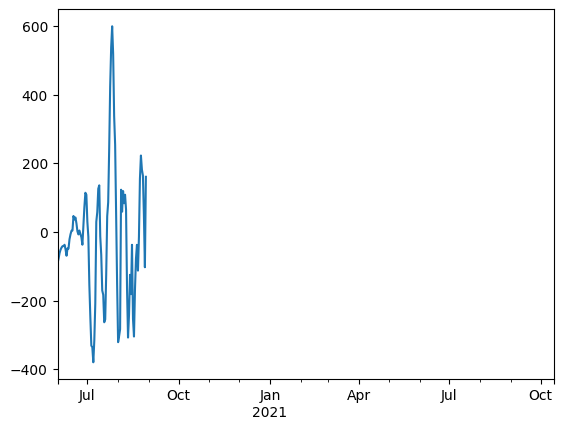

In [74]:
# Inspect the bias of the resulting output

diff = (res.derived_outputs[target] - bcm.targets[target].data)
print(diff.mean() / diff.std())
diff.plot();